<a href="https://colab.research.google.com/github/bulbul40/software-projects/blob/main/MASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

#  This will prompt you to upload from your computer
uploaded = files.upload()


Saving MASK.zip to MASK.zip


In [4]:
import zipfile
import os

# Unzip the uploaded file
with zipfile.ZipFile("MASK.zip", 'r') as zip_ref:
    zip_ref.extractall("MASK")  # Extract into a folder named MASK



In [7]:
# View the contents of the extracted folder
print("Classes found:", os.listdir("MASK"))
['with_mask', 'without_mask']



Classes found: ['data']


['with_mask', 'without_mask']

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = train_gen.flow_from_directory(
    "MASK/data",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_gen.flow_from_directory(
    "MASK/data",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [25]:
print("Class labels:", train_data.class_indices)


Class labels: {'with_mask': 0, 'without_mask': 1}


In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze pre-trained layers

# Add custom classifier layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # 2 classes: with_mask, without_mask

# Combine
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
146/189 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.8435 - loss: 0.3396

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.8650 - loss: 0.2992 - val_accuracy: 0.9715 - val_loss: 0.0724
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9850 - loss: 0.0472 - val_accuracy: 0.9821 - val_loss: 0.0584
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.9914 - loss: 0.0333 - val_accuracy: 0.9828 - val_loss: 0.0477
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9955 - loss: 0.0196 - val_accuracy: 0.9841 - val_loss: 0.0421
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.9975 - loss: 0.0143 - val_accuracy: 0.9854 - val_loss: 0.0424
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9978 - loss: 0.0131 - val_accuracy: 0.9848 - val_loss: 0.0408
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.9991 - loss: 0.0085 - val_accuracy: 0.9861 - val_loss: 0.0382
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - accuracy: 0.9991 - loss: 0.0064 - val_accuracy: 0.986

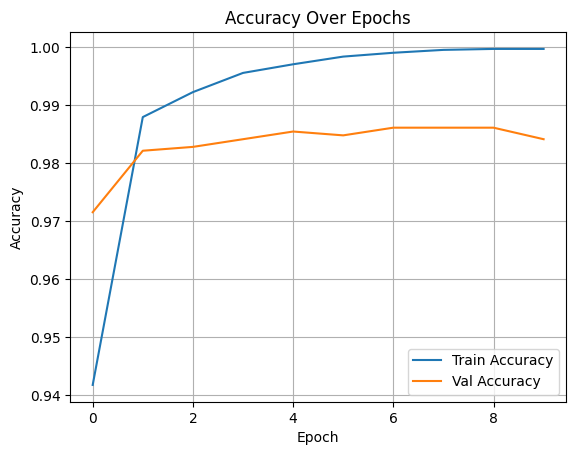

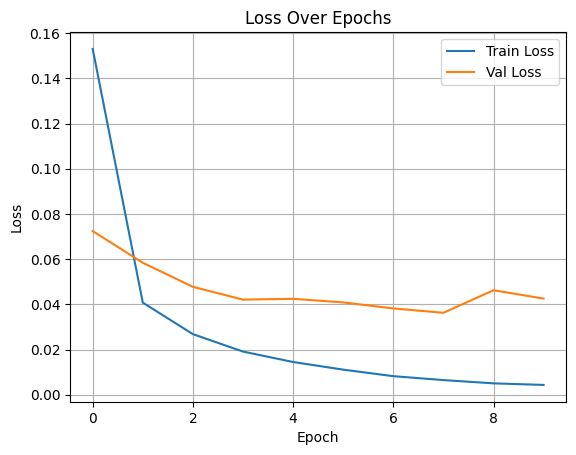

In [28]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
model.save("mask_classifier_model.h5")
print("Model saved as mask_classifier_model.h5")


Model saved as mask_classifier_model.h5
